In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import utils

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# 分類先クラスの名称リスト
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 分類先クラス数　今回は10になる
n_output = len(list(set(classes)))

# 結果確認
print(n_output)

10


In [4]:
# ドロップアウトテスト用データ
torch.manual_seed(0)
inputs = torch.randn(1, 10)
print(inputs)

tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845, -1.3986,  0.4033,  0.8380,
         -0.7193, -0.4033]])


In [5]:
# dropout関数の定義
dropout = nn.Dropout(0.5)

# 訓練フェーズでの挙動
dropout.train()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

# 予測フェーズでの挙動
dropout.eval()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

True
tensor([[ 0.0000, -0.5869, -0.0000,  0.0000, -0.0000, -2.7972,  0.0000,  0.0000,
         -0.0000, -0.8067]])
False
tensor([[ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845, -1.3986,  0.4033,  0.8380,
         -0.7193, -0.4033]])


In [ ]:
# 訓練データ用：正規化に追加で反転とRandomErasingを行う
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),   # ランダムに左右反転
    transforms.ToTensor(),                # テンソルに変換
    transforms.Normalize(0.5, 0.5),      # 正規化
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=True)    # ランダムに矩形領域を消去
])

Files already downloaded and verified
Files already downloaded and verified


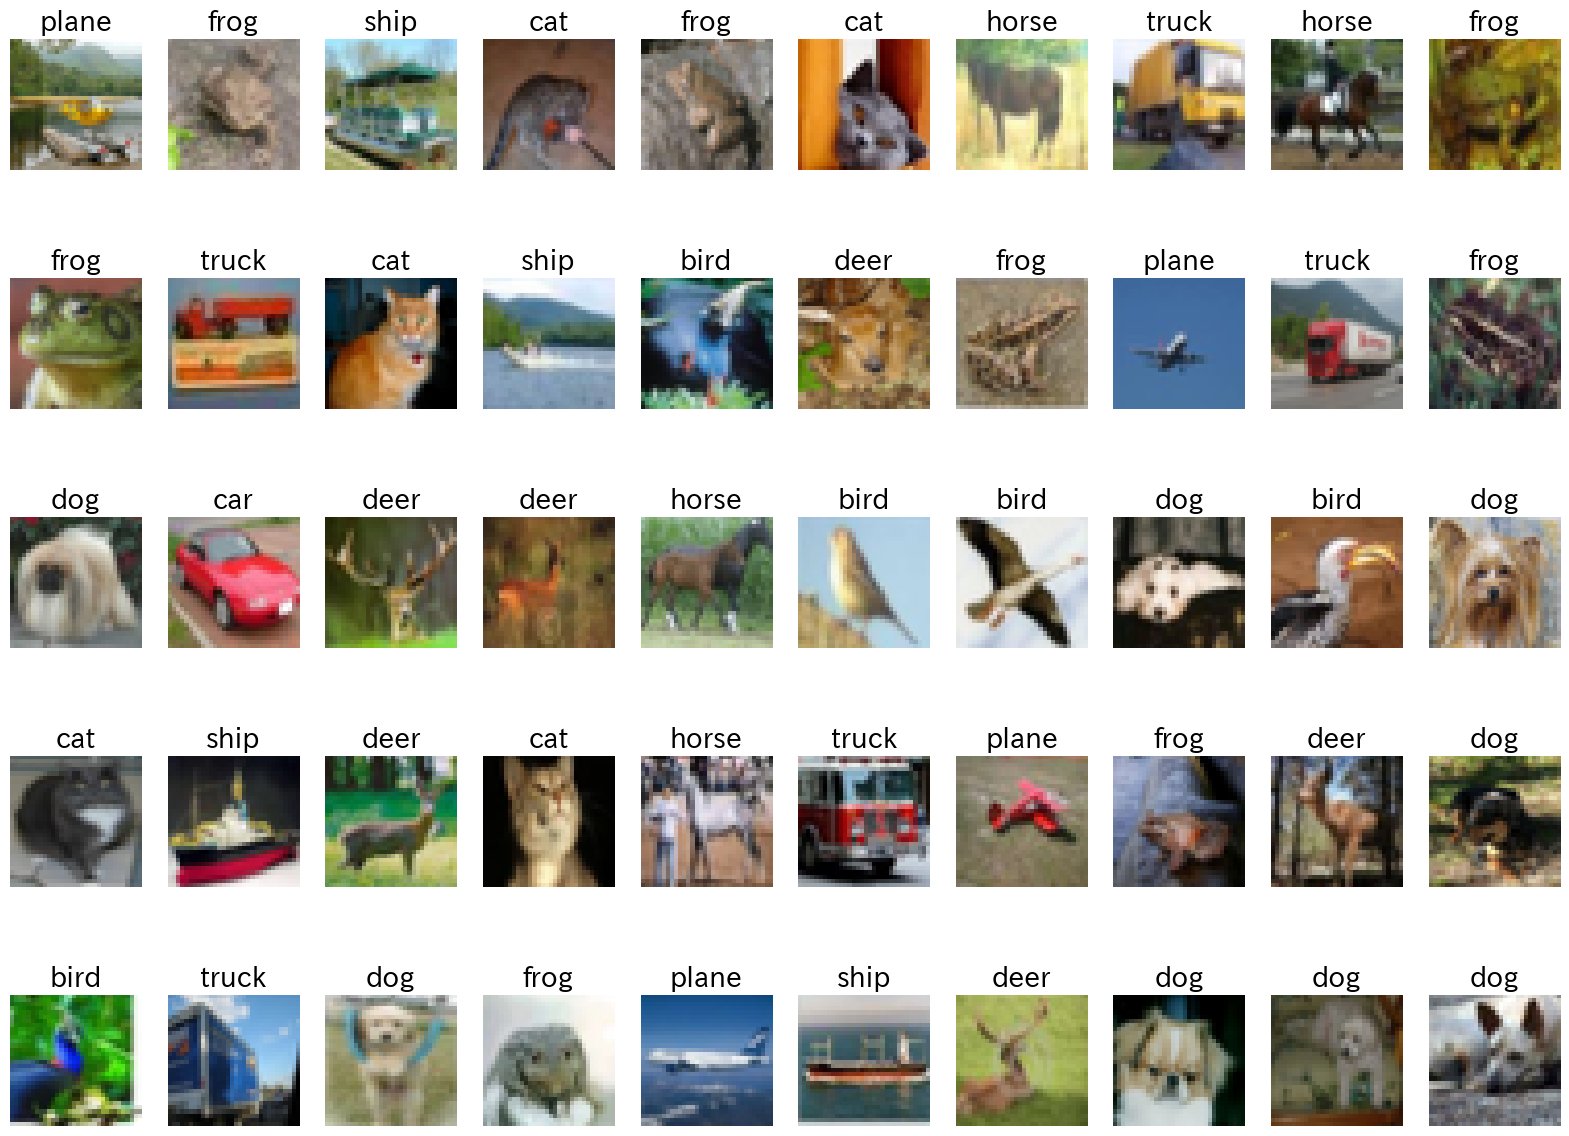

In [5]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

data_root = '../data'
train_set = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform
)
test_set = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=transform
)

batch_size = 100

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

# 最初の50個の画像を表示
utils.show_images_labels(train_loader, classes, None, None)

In [10]:
# 階層を深くしたCNN
class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1, 1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1, 1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1, 1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1, 1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1, 1))
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.l1 = nn.Linear(128 * 4 * 4, 512)
        self.l2 = nn.Linear(512, num_classes)
        self.flatten = nn.Flatten()

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [11]:
# インスタンス生成
utils.torch_seed()

lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))

In [12]:
# 学習
num_epochs = 50
history = utils.fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.30273 acc: 0.10450 val_loss: 2.30251, val_acc: 0.10190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 2.30248 acc: 0.11018 val_loss: 2.30232, val_acc: 0.15590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 2.30229 acc: 0.11880 val_loss: 2.30209, val_acc: 0.15670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 2.30197 acc: 0.13086 val_loss: 2.30164, val_acc: 0.17950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 2.30118 acc: 0.15908 val_loss: 2.30022, val_acc: 0.23630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 2.29755 acc: 0.18372 val_loss: 2.29117, val_acc: 0.21370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 2.21466 acc: 0.20554 val_loss: 2.05580, val_acc: 0.25580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 2.00582 acc: 0.26320 val_loss: 1.94802, val_acc: 0.28480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.92025 acc: 0.29868 val_loss: 1.83638, val_acc: 0.32470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.79999 acc: 0.34484 val_loss: 1.77207, val_acc: 0.35420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.71064 acc: 0.37366 val_loss: 1.63488, val_acc: 0.40650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.62634 acc: 0.40648 val_loss: 1.56260, val_acc: 0.42970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.55220 acc: 0.43528 val_loss: 1.49095, val_acc: 0.45970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.49143 acc: 0.45898 val_loss: 1.43937, val_acc: 0.47750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.44405 acc: 0.47854 val_loss: 1.41009, val_acc: 0.48360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.39730 acc: 0.49782 val_loss: 1.42155, val_acc: 0.48490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.35350 acc: 0.51446 val_loss: 1.34322, val_acc: 0.51220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.30814 acc: 0.53062 val_loss: 1.33893, val_acc: 0.51720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.26176 acc: 0.54870 val_loss: 1.24392, val_acc: 0.55610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.21442 acc: 0.56580 val_loss: 1.21642, val_acc: 0.56190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 1.16665 acc: 0.58508 val_loss: 1.17543, val_acc: 0.57900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 1.12047 acc: 0.60240 val_loss: 1.14689, val_acc: 0.59160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.07267 acc: 0.62336 val_loss: 1.10279, val_acc: 0.60670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.02691 acc: 0.63612 val_loss: 1.06495, val_acc: 0.62830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.98408 acc: 0.65490 val_loss: 1.06671, val_acc: 0.62440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.93778 acc: 0.66982 val_loss: 1.05245, val_acc: 0.62710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.89605 acc: 0.68684 val_loss: 1.00164, val_acc: 0.64780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.85380 acc: 0.69994 val_loss: 1.01994, val_acc: 0.63940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.81220 acc: 0.71798 val_loss: 1.04642, val_acc: 0.63990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.76663 acc: 0.73174 val_loss: 0.97495, val_acc: 0.65450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.72191 acc: 0.74700 val_loss: 1.03143, val_acc: 0.65420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.67727 acc: 0.76328 val_loss: 0.96915, val_acc: 0.67610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.62816 acc: 0.77876 val_loss: 1.00968, val_acc: 0.66220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.58033 acc: 0.79702 val_loss: 1.04947, val_acc: 0.66640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.53404 acc: 0.81394 val_loss: 1.08435, val_acc: 0.66300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.48253 acc: 0.83244 val_loss: 1.08298, val_acc: 0.67560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.42792 acc: 0.85054 val_loss: 1.11631, val_acc: 0.67240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.38204 acc: 0.86558 val_loss: 1.18047, val_acc: 0.67230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.32958 acc: 0.88436 val_loss: 1.20202, val_acc: 0.67150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.28293 acc: 0.90030 val_loss: 1.31375, val_acc: 0.66790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.24097 acc: 0.91664 val_loss: 1.40560, val_acc: 0.65600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.20429 acc: 0.92858 val_loss: 1.55550, val_acc: 0.66820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.17079 acc: 0.94122 val_loss: 1.57609, val_acc: 0.67360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.12696 acc: 0.95690 val_loss: 1.94322, val_acc: 0.64320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.10394 acc: 0.96472 val_loss: 1.80153, val_acc: 0.67360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.09611 acc: 0.96906 val_loss: 1.90500, val_acc: 0.65890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.06519 acc: 0.97978 val_loss: 2.21278, val_acc: 0.64640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.08067 acc: 0.97414 val_loss: 1.87423, val_acc: 0.66740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.05539 acc: 0.98260 val_loss: 2.19895, val_acc: 0.66680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.04871 acc: 0.98512 val_loss: 2.26554, val_acc: 0.65640


初期状態: 損失: 2.30251 精度: 0.10190
最終状態: 損失: 2.26554 精度: 0.65640


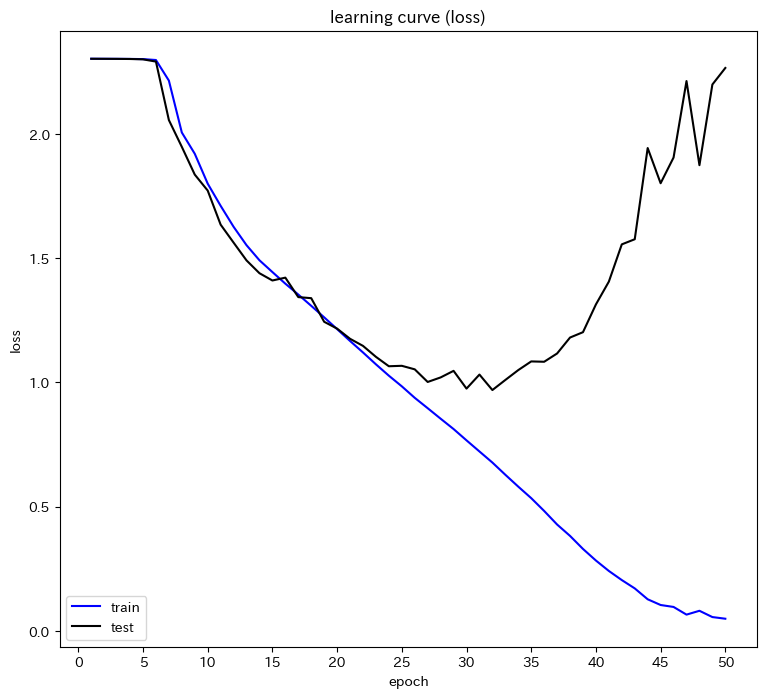

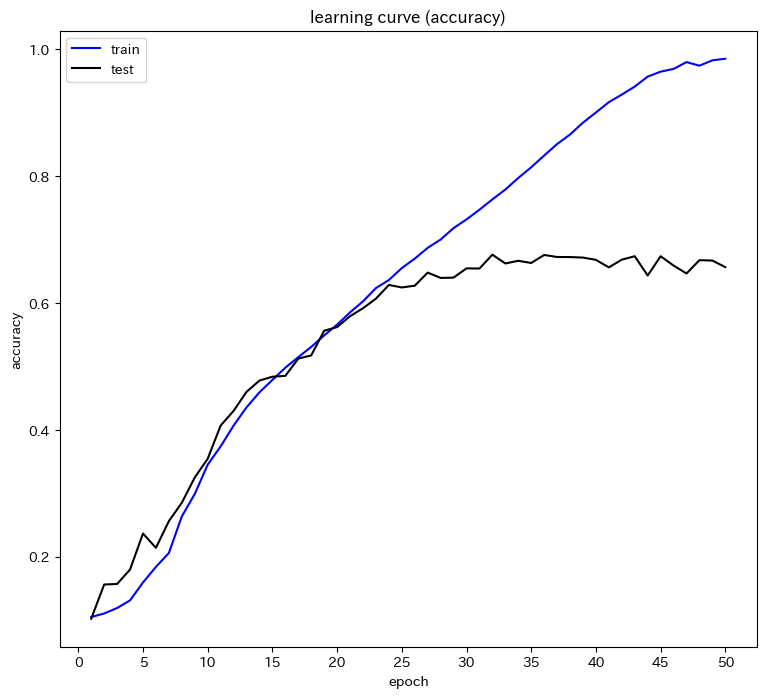

In [13]:
utils.evaluated_history(history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.24680 acc: 0.14118 val_loss: 1.98168, val_acc: 0.28110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.73364 acc: 0.35902 val_loss: 1.48413, val_acc: 0.44900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.37894 acc: 0.49738 val_loss: 1.26790, val_acc: 0.53720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.12967 acc: 0.59464 val_loss: 1.07028, val_acc: 0.61600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.93444 acc: 0.66974 val_loss: 0.93104, val_acc: 0.66310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.78225 acc: 0.72566 val_loss: 0.82895, val_acc: 0.71070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.64630 acc: 0.77278 val_loss: 0.81787, val_acc: 0.71760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.53783 acc: 0.81230 val_loss: 0.72898, val_acc: 0.74950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.43819 acc: 0.84518 val_loss: 0.70964, val_acc: 0.75660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.33319 acc: 0.88268 val_loss: 0.81537, val_acc: 0.74820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.25545 acc: 0.91030 val_loss: 0.85067, val_acc: 0.75630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.18598 acc: 0.93490 val_loss: 0.93966, val_acc: 0.75530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.15009 acc: 0.94760 val_loss: 1.04325, val_acc: 0.75870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.11871 acc: 0.95994 val_loss: 1.11968, val_acc: 0.75660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.10144 acc: 0.96448 val_loss: 1.24442, val_acc: 0.75380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.08270 acc: 0.97104 val_loss: 1.29987, val_acc: 0.75380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.07768 acc: 0.97340 val_loss: 1.30057, val_acc: 0.73460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.07046 acc: 0.97578 val_loss: 1.25584, val_acc: 0.76760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.05482 acc: 0.98170 val_loss: 1.34317, val_acc: 0.75990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.04629 acc: 0.98452 val_loss: 1.45758, val_acc: 0.75180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.05206 acc: 0.98300 val_loss: 1.47265, val_acc: 0.75680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.04064 acc: 0.98640 val_loss: 1.48357, val_acc: 0.76770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.04473 acc: 0.98440 val_loss: 1.57470, val_acc: 0.76370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.04204 acc: 0.98628 val_loss: 1.54499, val_acc: 0.75610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.03376 acc: 0.98878 val_loss: 1.68263, val_acc: 0.75980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.03046 acc: 0.99006 val_loss: 1.48230, val_acc: 0.76650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.02596 acc: 0.99096 val_loss: 1.69180, val_acc: 0.76310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.02567 acc: 0.99208 val_loss: 1.70881, val_acc: 0.76760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.03268 acc: 0.98978 val_loss: 1.63932, val_acc: 0.75540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.02589 acc: 0.99176 val_loss: 1.67276, val_acc: 0.76170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.01915 acc: 0.99340 val_loss: 1.92006, val_acc: 0.75980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.03054 acc: 0.98994 val_loss: 1.81433, val_acc: 0.75520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.01722 acc: 0.99442 val_loss: 1.84055, val_acc: 0.76320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.02614 acc: 0.99146 val_loss: 1.69913, val_acc: 0.76220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.02554 acc: 0.99176 val_loss: 1.83174, val_acc: 0.76410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.01692 acc: 0.99470 val_loss: 1.94745, val_acc: 0.76480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.02137 acc: 0.99304 val_loss: 1.87932, val_acc: 0.76480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.02950 acc: 0.99068 val_loss: 1.75962, val_acc: 0.75550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.01816 acc: 0.99416 val_loss: 1.93468, val_acc: 0.76460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.01861 acc: 0.99418 val_loss: 1.91515, val_acc: 0.76050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.01737 acc: 0.99408 val_loss: 1.87893, val_acc: 0.77070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.01061 acc: 0.99658 val_loss: 1.95517, val_acc: 0.76430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.01885 acc: 0.99398 val_loss: 1.92906, val_acc: 0.77280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.01931 acc: 0.99418 val_loss: 2.01627, val_acc: 0.75670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.02179 acc: 0.99314 val_loss: 1.84426, val_acc: 0.77220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00959 acc: 0.99672 val_loss: 2.09710, val_acc: 0.77030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.01150 acc: 0.99618 val_loss: 2.21565, val_acc: 0.76810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.01785 acc: 0.99390 val_loss: 1.95573, val_acc: 0.76960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.01374 acc: 0.99564 val_loss: 1.98330, val_acc: 0.76850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.01524 acc: 0.99480 val_loss: 2.06739, val_acc: 0.76040
初期状態: 損失: 1.98168 精度: 0.28110
最終状態: 損失: 2.06739 精度: 0.76040


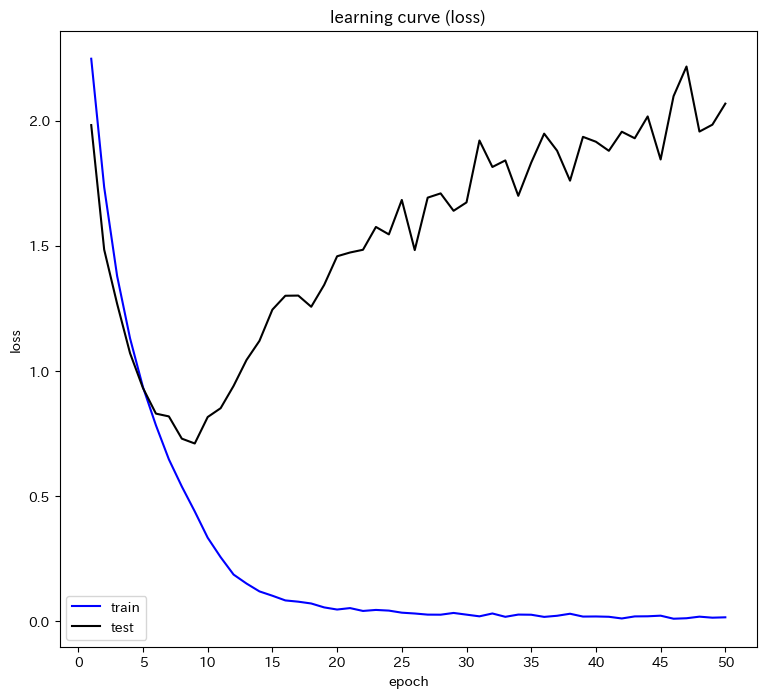

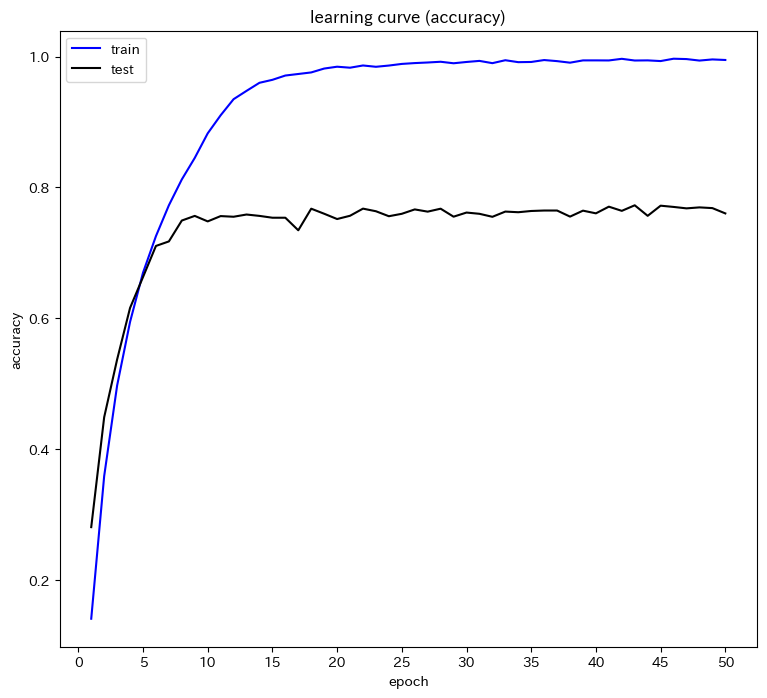

In [16]:
# 最適化関数の工夫
utils.torch_seed()

lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history2 = np.zeros((0, 5))

# 学習
history2 = utils.fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)

utils.evaluated_history(history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.55096 acc: 0.42800 val_loss: 1.25854, val_acc: 0.53760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.03961 acc: 0.62766 val_loss: 0.98302, val_acc: 0.65250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.82102 acc: 0.70992 val_loss: 0.81449, val_acc: 0.71270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.67228 acc: 0.76328 val_loss: 0.75218, val_acc: 0.73920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.55221 acc: 0.80476 val_loss: 0.71855, val_acc: 0.75550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.44376 acc: 0.84210 val_loss: 0.73972, val_acc: 0.75690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.34892 acc: 0.87760 val_loss: 0.75942, val_acc: 0.77150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.26191 acc: 0.90676 val_loss: 0.84151, val_acc: 0.76210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.20323 acc: 0.92818 val_loss: 0.87638, val_acc: 0.76960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.15525 acc: 0.94608 val_loss: 1.03268, val_acc: 0.76780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.12808 acc: 0.95452 val_loss: 1.13856, val_acc: 0.76300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.10554 acc: 0.96336 val_loss: 1.21443, val_acc: 0.76040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.09909 acc: 0.96592 val_loss: 1.35227, val_acc: 0.74670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.09344 acc: 0.96800 val_loss: 1.27019, val_acc: 0.76590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.08867 acc: 0.96952 val_loss: 1.27408, val_acc: 0.75520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.07758 acc: 0.97366 val_loss: 1.45546, val_acc: 0.75440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.08358 acc: 0.97216 val_loss: 1.33723, val_acc: 0.76880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.06977 acc: 0.97574 val_loss: 1.60291, val_acc: 0.75300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.08555 acc: 0.97118 val_loss: 1.45415, val_acc: 0.74640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.06462 acc: 0.97836 val_loss: 1.67603, val_acc: 0.75860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.07096 acc: 0.97644 val_loss: 1.57826, val_acc: 0.76570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.06117 acc: 0.97996 val_loss: 1.63987, val_acc: 0.75950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.06698 acc: 0.97794 val_loss: 1.60243, val_acc: 0.76020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.06422 acc: 0.97946 val_loss: 1.50738, val_acc: 0.75650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.06062 acc: 0.97998 val_loss: 1.59689, val_acc: 0.75750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.05701 acc: 0.98134 val_loss: 1.61581, val_acc: 0.76460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.06050 acc: 0.98022 val_loss: 1.76750, val_acc: 0.74890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.05565 acc: 0.98192 val_loss: 1.79018, val_acc: 0.76100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.06884 acc: 0.97810 val_loss: 1.70245, val_acc: 0.76420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.05776 acc: 0.98144 val_loss: 1.86681, val_acc: 0.75900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.05920 acc: 0.98128 val_loss: 1.76691, val_acc: 0.76020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.04822 acc: 0.98450 val_loss: 1.84498, val_acc: 0.75650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.04934 acc: 0.98486 val_loss: 1.96215, val_acc: 0.76090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.05735 acc: 0.98200 val_loss: 1.85158, val_acc: 0.76070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.04962 acc: 0.98462 val_loss: 1.91372, val_acc: 0.75660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.05865 acc: 0.98184 val_loss: 1.98584, val_acc: 0.75220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.05641 acc: 0.98270 val_loss: 1.91124, val_acc: 0.75350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.05031 acc: 0.98438 val_loss: 1.84492, val_acc: 0.75810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.05124 acc: 0.98440 val_loss: 1.92449, val_acc: 0.76360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.04455 acc: 0.98588 val_loss: 1.86894, val_acc: 0.76670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.06239 acc: 0.98144 val_loss: 2.02308, val_acc: 0.75380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.05114 acc: 0.98406 val_loss: 1.97814, val_acc: 0.75470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.04490 acc: 0.98644 val_loss: 2.04190, val_acc: 0.75240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.05082 acc: 0.98424 val_loss: 1.92915, val_acc: 0.75980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.04924 acc: 0.98478 val_loss: 1.89027, val_acc: 0.75560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.04719 acc: 0.98590 val_loss: 1.95958, val_acc: 0.75800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.05332 acc: 0.98424 val_loss: 2.02539, val_acc: 0.75130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.04959 acc: 0.98560 val_loss: 2.16981, val_acc: 0.75200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.05163 acc: 0.98408 val_loss: 2.11957, val_acc: 0.75370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.05100 acc: 0.98562 val_loss: 2.01645, val_acc: 0.75430
初期状態: 損失: 1.25854 精度: 0.53760
最終状態: 損失: 2.01645 精度: 0.75430


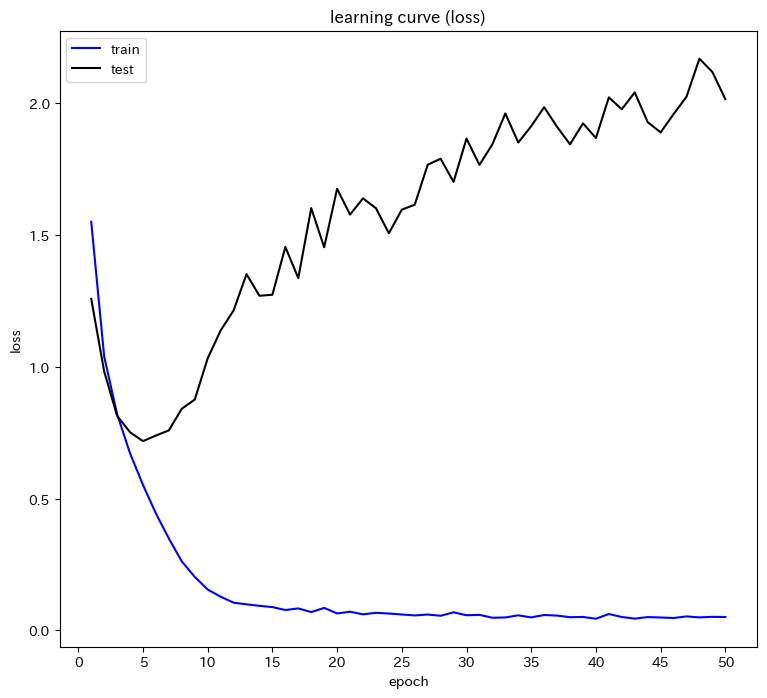

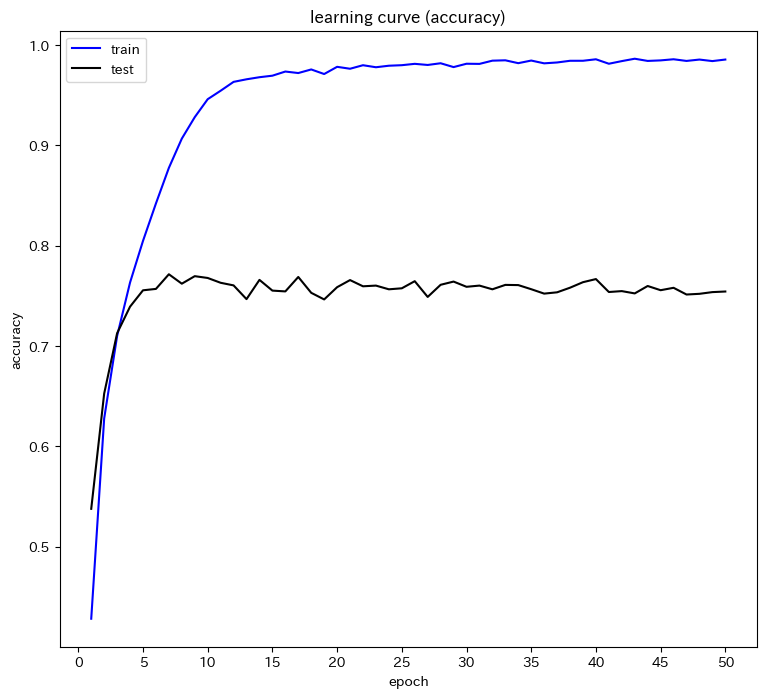

In [17]:
# 最適化関数の工夫
utils.torch_seed()

lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history3 = np.zeros((0, 5))

# 学習
history3 = utils.fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)

utils.evaluated_history(history3)

In [25]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.72142 acc: 0.36194 val_loss: 1.39332, val_acc: 0.49500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.31264 acc: 0.52192 val_loss: 1.08026, val_acc: 0.60660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.12225 acc: 0.59950 val_loss: 0.98532, val_acc: 0.64630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.00532 acc: 0.64432 val_loss: 0.85055, val_acc: 0.69970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.92014 acc: 0.67570 val_loss: 0.80853, val_acc: 0.71890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.85375 acc: 0.70232 val_loss: 0.74413, val_acc: 0.73680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.79185 acc: 0.72456 val_loss: 0.71006, val_acc: 0.74780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.75464 acc: 0.73806 val_loss: 0.68196, val_acc: 0.76430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.71690 acc: 0.75094 val_loss: 0.65583, val_acc: 0.77290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.68776 acc: 0.76220 val_loss: 0.64598, val_acc: 0.77870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.66109 acc: 0.77100 val_loss: 0.64803, val_acc: 0.77530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.64288 acc: 0.77828 val_loss: 0.59578, val_acc: 0.79370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.60935 acc: 0.78918 val_loss: 0.59097, val_acc: 0.80060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.59792 acc: 0.79292 val_loss: 0.58938, val_acc: 0.79960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.58884 acc: 0.79640 val_loss: 0.59785, val_acc: 0.79790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.57107 acc: 0.80376 val_loss: 0.57770, val_acc: 0.80510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.55575 acc: 0.80894 val_loss: 0.57012, val_acc: 0.80860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.54409 acc: 0.81136 val_loss: 0.58169, val_acc: 0.80570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.53728 acc: 0.81494 val_loss: 0.56077, val_acc: 0.81250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.52527 acc: 0.81898 val_loss: 0.58940, val_acc: 0.80440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51860 acc: 0.82174 val_loss: 0.55298, val_acc: 0.81520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51251 acc: 0.82234 val_loss: 0.56100, val_acc: 0.81510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50757 acc: 0.82358 val_loss: 0.54495, val_acc: 0.81900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49612 acc: 0.82628 val_loss: 0.53591, val_acc: 0.82280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49074 acc: 0.83050 val_loss: 0.54573, val_acc: 0.81630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48699 acc: 0.83228 val_loss: 0.55413, val_acc: 0.81930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.47646 acc: 0.83566 val_loss: 0.55617, val_acc: 0.81850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47404 acc: 0.83528 val_loss: 0.56609, val_acc: 0.81600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.46626 acc: 0.83718 val_loss: 0.53997, val_acc: 0.82240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.46249 acc: 0.83876 val_loss: 0.54105, val_acc: 0.82360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.45296 acc: 0.84286 val_loss: 0.54315, val_acc: 0.82690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46390 acc: 0.83994 val_loss: 0.55158, val_acc: 0.82230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.44321 acc: 0.84596 val_loss: 0.53603, val_acc: 0.82100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.44889 acc: 0.84354 val_loss: 0.52388, val_acc: 0.82650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.43968 acc: 0.84576 val_loss: 0.54941, val_acc: 0.82330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.43981 acc: 0.84820 val_loss: 0.54922, val_acc: 0.82530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.42719 acc: 0.85288 val_loss: 0.55660, val_acc: 0.82520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.41961 acc: 0.85482 val_loss: 0.52819, val_acc: 0.82980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.42932 acc: 0.85166 val_loss: 0.54606, val_acc: 0.82830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.41740 acc: 0.85450 val_loss: 0.52591, val_acc: 0.83480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.42506 acc: 0.85214 val_loss: 0.52995, val_acc: 0.82800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.41461 acc: 0.85536 val_loss: 0.56951, val_acc: 0.81950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.41260 acc: 0.85810 val_loss: 0.52238, val_acc: 0.83310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.41075 acc: 0.85682 val_loss: 0.53589, val_acc: 0.83190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.41272 acc: 0.85812 val_loss: 0.52376, val_acc: 0.83130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.40115 acc: 0.86056 val_loss: 0.53273, val_acc: 0.83620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.40583 acc: 0.85914 val_loss: 0.52957, val_acc: 0.83430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.40287 acc: 0.85982 val_loss: 0.57035, val_acc: 0.82360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.40129 acc: 0.86022 val_loss: 0.54362, val_acc: 0.82930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.39317 acc: 0.86152 val_loss: 0.57563, val_acc: 0.82650
初期状態: 損失: 1.39332 精度: 0.49500
最終状態: 損失: 0.57563 精度: 0.82650


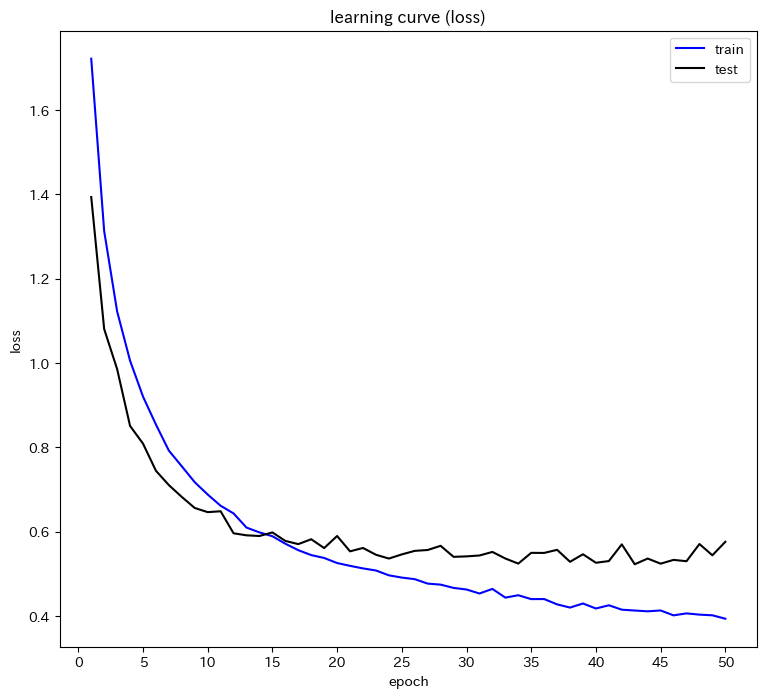

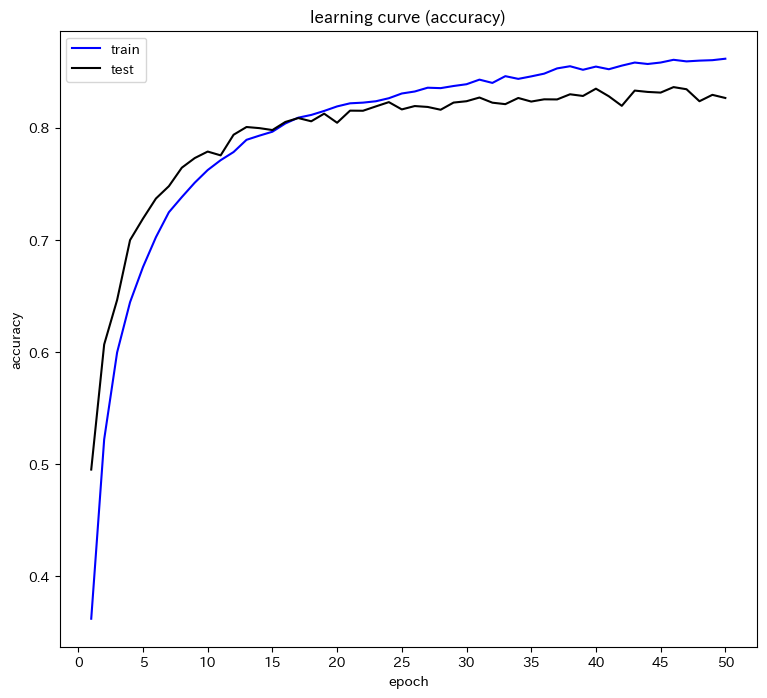

In [26]:
# 最適化関数の工夫
utils.torch_seed()

net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history4 = np.zeros((0, 5))

# 学習
history4 = utils.fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history4)

utils.evaluated_history(history4)

In [27]:
# バッチ正規化を追加したCNN
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        # バッチ正規化にもパラメータがあるためそれぞれインスタンスを作成する
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.49737 acc: 0.44740 val_loss: 1.19645, val_acc: 0.56860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.11356 acc: 0.60242 val_loss: 0.90349, val_acc: 0.67920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.96288 acc: 0.66030 val_loss: 0.79955, val_acc: 0.71520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.87584 acc: 0.69506 val_loss: 0.75353, val_acc: 0.74000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.80817 acc: 0.71812 val_loss: 0.73084, val_acc: 0.74420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.75691 acc: 0.74130 val_loss: 0.66714, val_acc: 0.76900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.71725 acc: 0.75586 val_loss: 0.62230, val_acc: 0.78380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.68107 acc: 0.76508 val_loss: 0.64972, val_acc: 0.78250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.64522 acc: 0.78040 val_loss: 0.62186, val_acc: 0.78590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.62175 acc: 0.78686 val_loss: 0.57621, val_acc: 0.79790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.59371 acc: 0.79906 val_loss: 0.54633, val_acc: 0.81820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.57131 acc: 0.80696 val_loss: 0.52640, val_acc: 0.82400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.55183 acc: 0.81284 val_loss: 0.50914, val_acc: 0.82900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.52893 acc: 0.82210 val_loss: 0.51257, val_acc: 0.82680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.51421 acc: 0.82692 val_loss: 0.50084, val_acc: 0.82760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.49291 acc: 0.83306 val_loss: 0.46899, val_acc: 0.84210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.47759 acc: 0.83882 val_loss: 0.50872, val_acc: 0.83470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.46305 acc: 0.84456 val_loss: 0.46485, val_acc: 0.84580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.45211 acc: 0.84702 val_loss: 0.47715, val_acc: 0.84770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.43556 acc: 0.85342 val_loss: 0.46729, val_acc: 0.84790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.41954 acc: 0.85792 val_loss: 0.44922, val_acc: 0.85460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.41147 acc: 0.86098 val_loss: 0.46300, val_acc: 0.85030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.40003 acc: 0.86442 val_loss: 0.52526, val_acc: 0.83480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.39688 acc: 0.86566 val_loss: 0.45104, val_acc: 0.85340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.37416 acc: 0.87268 val_loss: 0.45106, val_acc: 0.85590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.37081 acc: 0.87568 val_loss: 0.44842, val_acc: 0.86020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.36191 acc: 0.87802 val_loss: 0.46368, val_acc: 0.86040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.35249 acc: 0.88102 val_loss: 0.45277, val_acc: 0.85960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.34543 acc: 0.88206 val_loss: 0.47592, val_acc: 0.85180


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.34027 acc: 0.88462 val_loss: 0.45733, val_acc: 0.85830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.32948 acc: 0.88840 val_loss: 0.43956, val_acc: 0.86410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.32762 acc: 0.88834 val_loss: 0.44739, val_acc: 0.86190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.32257 acc: 0.89168 val_loss: 0.43395, val_acc: 0.86150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.31376 acc: 0.89404 val_loss: 0.44037, val_acc: 0.86420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.30813 acc: 0.89538 val_loss: 0.45642, val_acc: 0.86240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.30206 acc: 0.89782 val_loss: 0.44338, val_acc: 0.86450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.29814 acc: 0.89926 val_loss: 0.46023, val_acc: 0.85920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.29091 acc: 0.90008 val_loss: 0.46594, val_acc: 0.86250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.29454 acc: 0.89904 val_loss: 0.43991, val_acc: 0.86730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.28546 acc: 0.90308 val_loss: 0.43707, val_acc: 0.86410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.27901 acc: 0.90348 val_loss: 0.44919, val_acc: 0.86560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.27043 acc: 0.90828 val_loss: 0.48595, val_acc: 0.85930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.27198 acc: 0.90646 val_loss: 0.44135, val_acc: 0.86980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.27437 acc: 0.90726 val_loss: 0.46659, val_acc: 0.86630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.26914 acc: 0.90940 val_loss: 0.46503, val_acc: 0.86880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.26541 acc: 0.90862 val_loss: 0.44532, val_acc: 0.86600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.26208 acc: 0.91076 val_loss: 0.42865, val_acc: 0.87060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.25810 acc: 0.91034 val_loss: 0.47421, val_acc: 0.86530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.24883 acc: 0.91490 val_loss: 0.46666, val_acc: 0.86710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.24841 acc: 0.91496 val_loss: 0.46283, val_acc: 0.86800
初期状態: 損失: 1.19645 精度: 0.56860
最終状態: 損失: 0.46283 精度: 0.86800


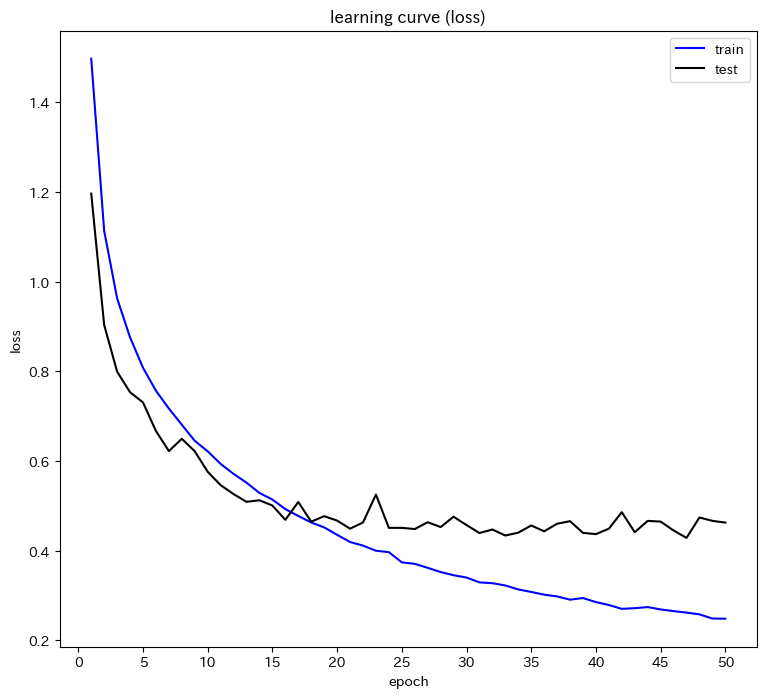

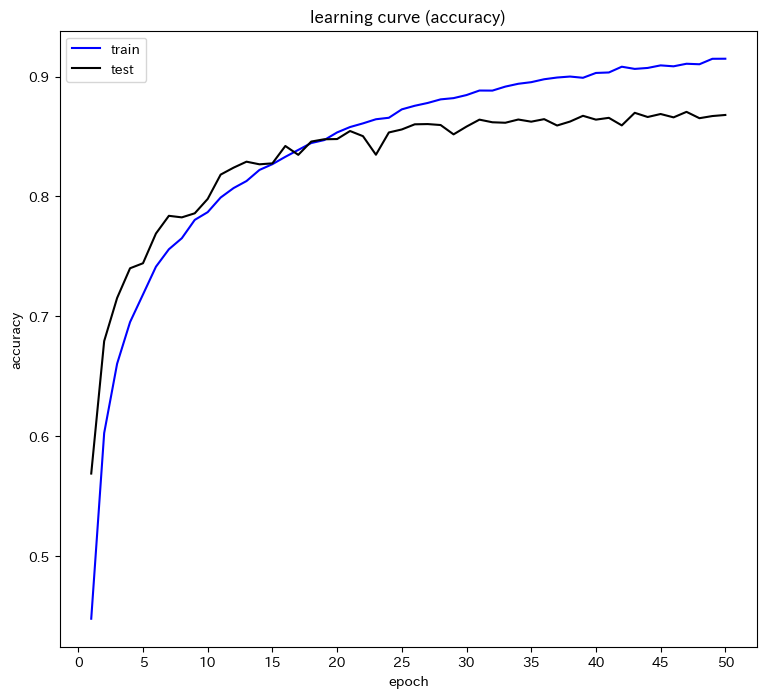

In [28]:
# 最適化関数の工夫
utils.torch_seed()

lr = 0.01
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history5 = np.zeros((0, 5))

# 学習
history5 = utils.fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history5)

utils.evaluated_history(history5)

In [29]:
# Data Augmentationを追加したCNN
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),   # ランダムに左右反転
    transforms.ToTensor(),                # テンソルに変換
    transforms.Normalize(0.5, 0.5),      # 正規化
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)    # ランダムに矩形領域を消去
])

Files already downloaded and verified


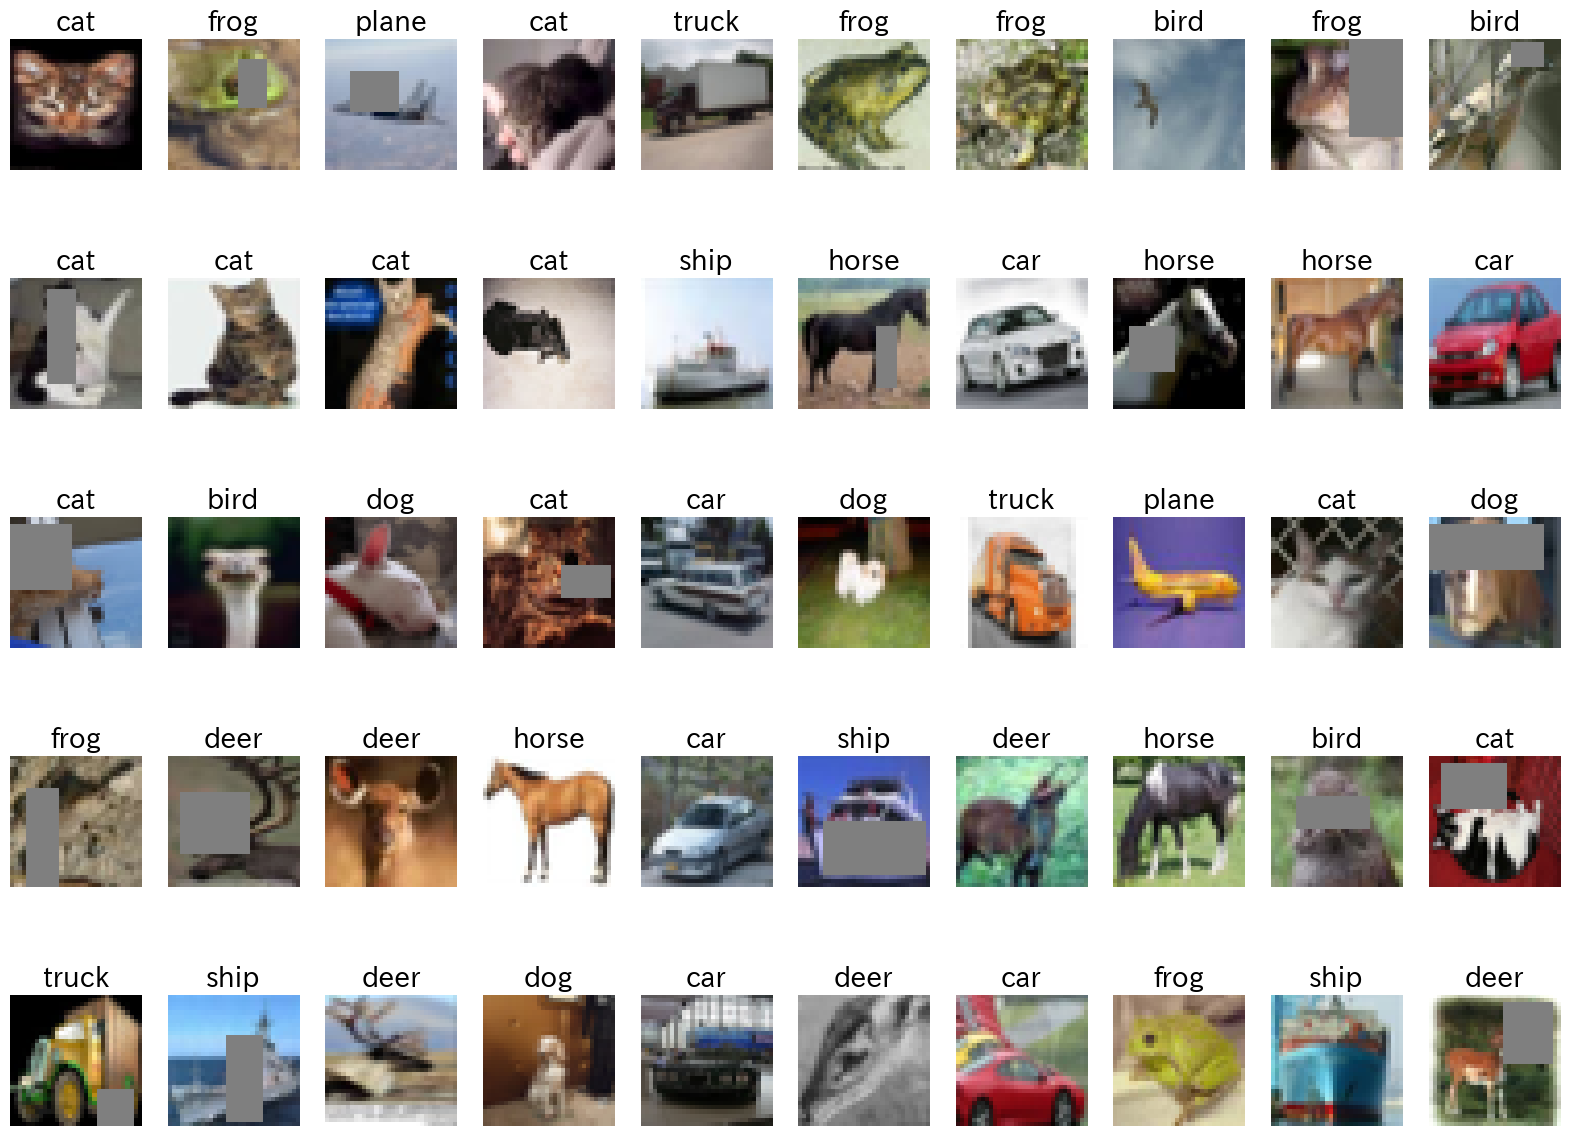

In [30]:
train_set2 = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform_train
)
batch_size = 100
train_loader2 = DataLoader(
    train_set2,
    batch_size=batch_size,
    shuffle=True
)
# transformの確認
utils.torch_seed()
utils.show_images_labels(train_loader2, classes, None, None)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.61970 acc: 0.39754 val_loss: 1.26348, val_acc: 0.55100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.28242 acc: 0.54132 val_loss: 1.06335, val_acc: 0.62310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.14171 acc: 0.59470 val_loss: 0.89418, val_acc: 0.66770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.06414 acc: 0.62402 val_loss: 0.82993, val_acc: 0.70410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.00789 acc: 0.64738 val_loss: 0.78692, val_acc: 0.72630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.96150 acc: 0.66486 val_loss: 0.73282, val_acc: 0.74360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.93211 acc: 0.67942 val_loss: 0.76491, val_acc: 0.74160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.89754 acc: 0.69006 val_loss: 0.66452, val_acc: 0.77480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.86482 acc: 0.70486 val_loss: 0.65882, val_acc: 0.77640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.84069 acc: 0.71174 val_loss: 0.77605, val_acc: 0.75240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.81408 acc: 0.72166 val_loss: 0.60740, val_acc: 0.79440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.79682 acc: 0.73004 val_loss: 0.59163, val_acc: 0.80240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.77916 acc: 0.73816 val_loss: 0.56569, val_acc: 0.80750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.75809 acc: 0.74376 val_loss: 0.56320, val_acc: 0.80500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.74176 acc: 0.75032 val_loss: 0.54564, val_acc: 0.81430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.73587 acc: 0.75328 val_loss: 0.52117, val_acc: 0.82000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.71903 acc: 0.75820 val_loss: 0.49633, val_acc: 0.83300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.70269 acc: 0.76518 val_loss: 0.55729, val_acc: 0.81250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.68448 acc: 0.77112 val_loss: 0.48406, val_acc: 0.83740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.68282 acc: 0.77166 val_loss: 0.47507, val_acc: 0.83750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.66673 acc: 0.77800 val_loss: 0.48259, val_acc: 0.83630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.65906 acc: 0.78200 val_loss: 0.49932, val_acc: 0.83990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.64638 acc: 0.78424 val_loss: 0.46890, val_acc: 0.84480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.64336 acc: 0.78710 val_loss: 0.45868, val_acc: 0.84570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.63462 acc: 0.78950 val_loss: 0.47911, val_acc: 0.84100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.62172 acc: 0.79356 val_loss: 0.47147, val_acc: 0.84700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.61638 acc: 0.79360 val_loss: 0.49247, val_acc: 0.83820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.60268 acc: 0.79796 val_loss: 0.49029, val_acc: 0.83970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.59844 acc: 0.80108 val_loss: 0.42432, val_acc: 0.86240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.59264 acc: 0.80332 val_loss: 0.43067, val_acc: 0.85990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.58939 acc: 0.80524 val_loss: 0.45266, val_acc: 0.85270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.58126 acc: 0.80546 val_loss: 0.42111, val_acc: 0.86240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.57766 acc: 0.80698 val_loss: 0.41972, val_acc: 0.86170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.56448 acc: 0.81352 val_loss: 0.44099, val_acc: 0.85610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.55770 acc: 0.81432 val_loss: 0.44786, val_acc: 0.85010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.54537 acc: 0.81654 val_loss: 0.42376, val_acc: 0.86230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.54004 acc: 0.82072 val_loss: 0.40330, val_acc: 0.86730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.54386 acc: 0.81852 val_loss: 0.40198, val_acc: 0.86280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.52842 acc: 0.82380 val_loss: 0.42895, val_acc: 0.86020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.52909 acc: 0.82458 val_loss: 0.42387, val_acc: 0.86250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.52317 acc: 0.82586 val_loss: 0.40112, val_acc: 0.86890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.51786 acc: 0.82648 val_loss: 0.39963, val_acc: 0.87100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.51407 acc: 0.82636 val_loss: 0.39767, val_acc: 0.86880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.51095 acc: 0.82948 val_loss: 0.40628, val_acc: 0.86750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.50422 acc: 0.83122 val_loss: 0.42435, val_acc: 0.85930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.49512 acc: 0.83382 val_loss: 0.39918, val_acc: 0.87190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.49642 acc: 0.83282 val_loss: 0.39777, val_acc: 0.86920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.49602 acc: 0.83206 val_loss: 0.40184, val_acc: 0.87020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.49213 acc: 0.83436 val_loss: 0.38293, val_acc: 0.87500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.48473 acc: 0.83698 val_loss: 0.39754, val_acc: 0.87250
初期状態: 損失: 1.26348 精度: 0.55100
最終状態: 損失: 0.39754 精度: 0.87250


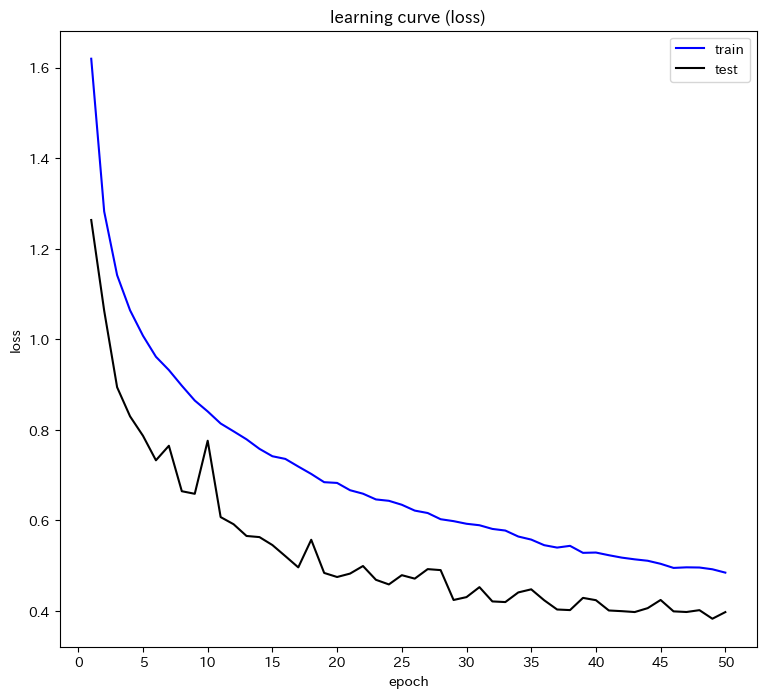

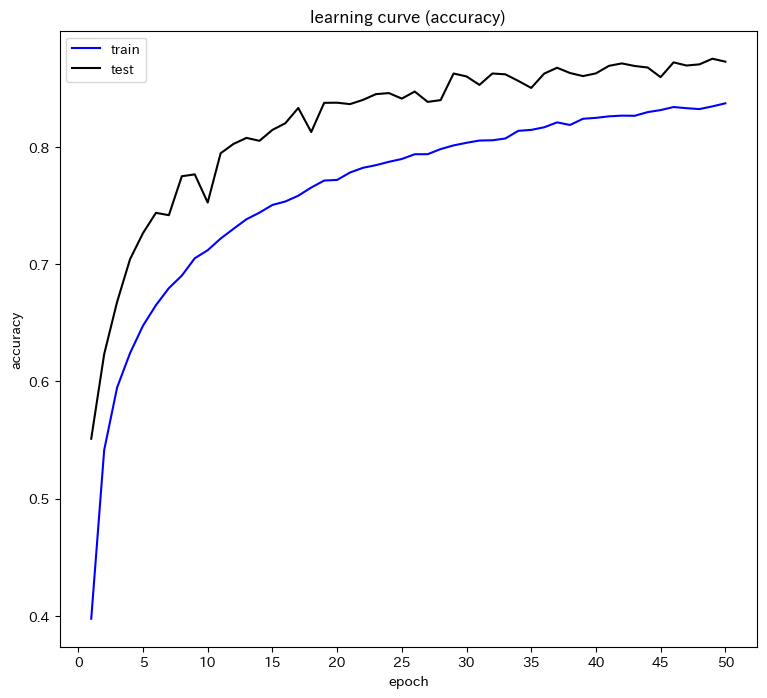

In [31]:
# 最適化関数の工夫
utils.torch_seed()

lr = 0.01
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history6 = np.zeros((0, 5))

# 学習
history6 = utils.fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader, device, history6)

utils.evaluated_history(history6)

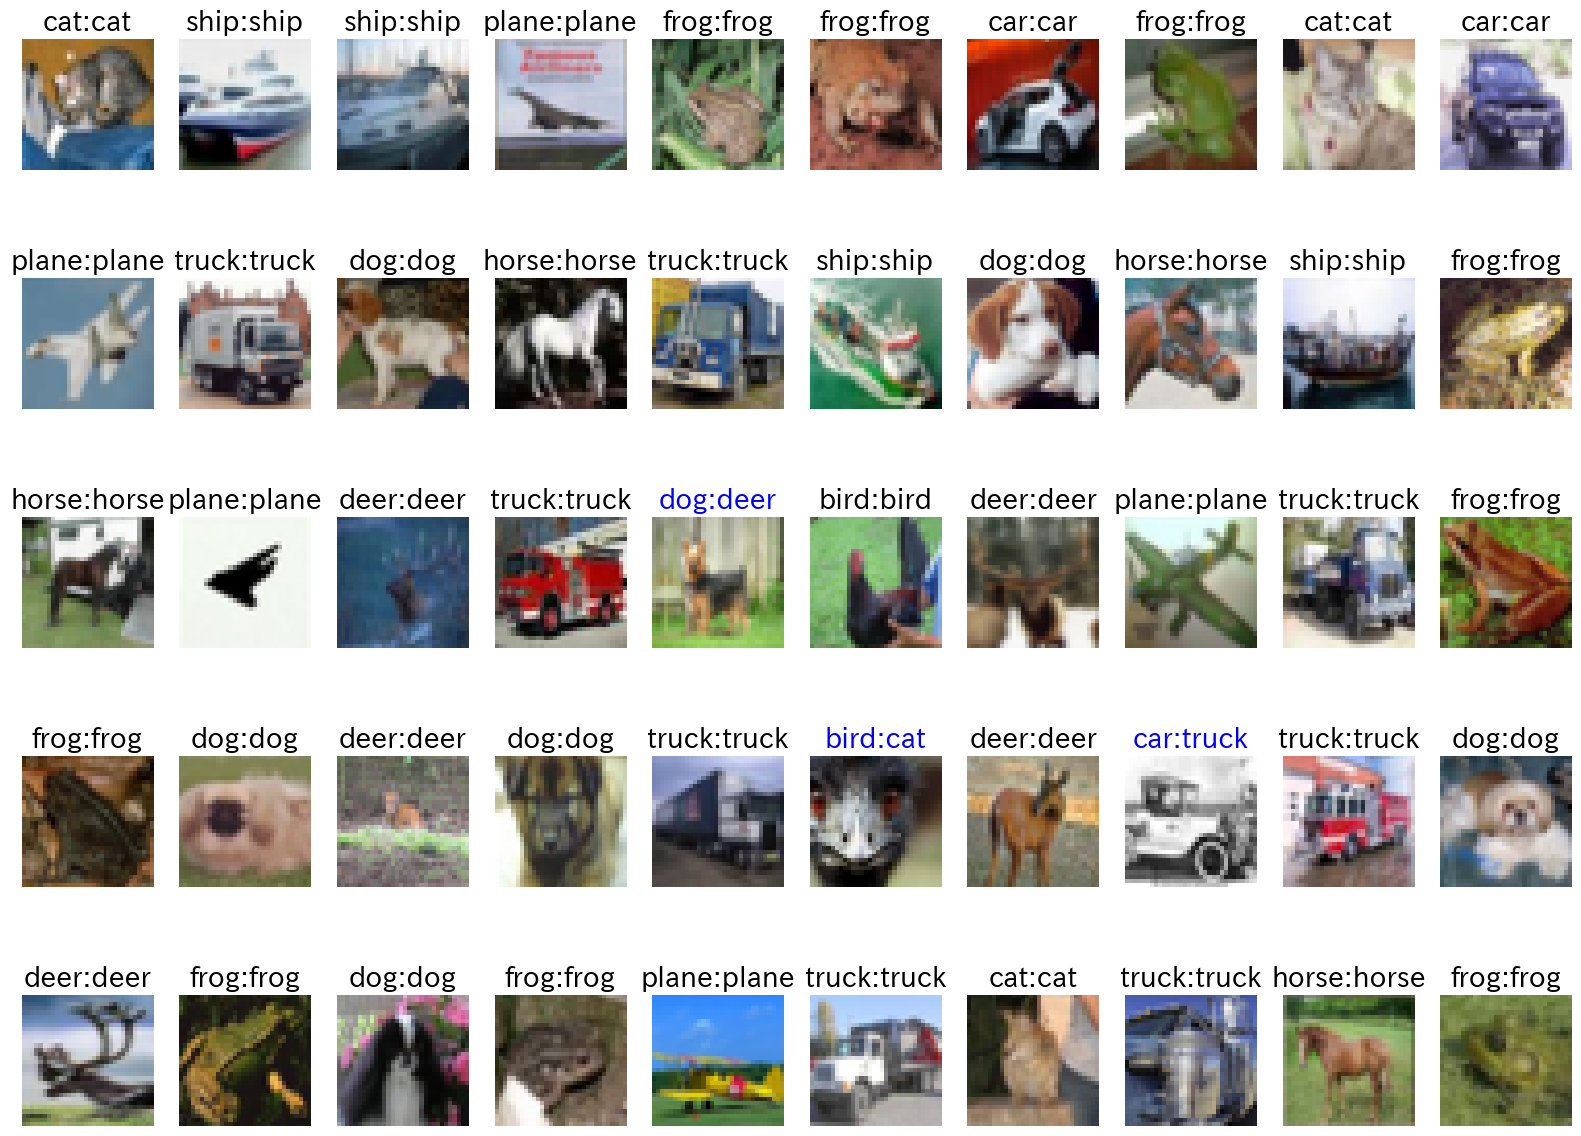

In [32]:
# テストデータの先頭50個の識別可否の確認
utils.show_images_labels(test_loader, classes, net, device)

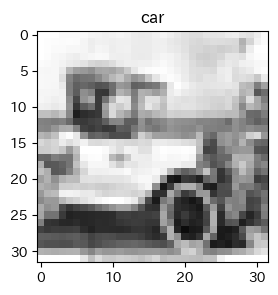

In [33]:
# 間違えた38番目のデータを抽出
for images, labels in test_loader:
    break
image = images[37]
label = labels[37]

# イメージを表示して確認
plt.figure(figsize=(3,3))
w = image.numpy().copy()
w2 = np.transpose(w, (1, 2, 0))
w3 = (w2 + 1)/2 
plt.title(classes[label])
plt.imshow(w3)
plt.show()

In [34]:
image = image.view(1, 3, 32, 32).to(device)
output = net(image)

# ラベル別の確率値を表示
probs = torch.softmax(output, dim=1)
probs_np = probs.data.to('cpu').numpy()[0]
values = np.frompyfunc(lambda x: f'{x:.04f}', 1, 1)(probs_np)
names = np.array(classes)
tbl = np.array([names, values]).T
print(tbl)

[['plane' '0.0000']
 ['car' '0.1656']
 ['bird' '0.0000']
 ['cat' '0.0000']
 ['deer' '0.0000']
 ['dog' '0.0000']
 ['frog' '0.0000']
 ['horse' '0.0000']
 ['ship' '0.0005']
 ['truck' '0.8339']]
